HW

In [1]:
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn import preprocessing
from functions import *

data = pd.read_csv("fr.openfoodfacts.org.products.csv", sep='\t', error_bad_lines=False, low_memory=False) # raw dataset

data.head()


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
print(len(data['categories'].unique()))

36983


In [2]:
len(data["code"])


320772

In [3]:
len(data["code"].unique())

320750

In [3]:
entries = data.shape[0]
for col in data.columns: 
    missing_values = data[col].isnull().sum()
    if missing_values > entries / 2:
        data = data.drop([col],axis=1)


In [6]:
drop_cols = ["url", "creator", "created_t", "created_datetime", "last_modified_t", "last_modified_datetime",
             "brands_tags", "countries", "countries_tags", "countries_fr", "ingredients_from_palm_oil_n",
             "ingredients_that_may_be_from_palm_oil_n", "states", "states_tags", "states_fr",
             "nutrition-score-fr_100g","nutrition_grade_fr","code","additives"]
#data = data.drop(drop_cols, axis=1)

for col in data.columns:
    print(col)
    
print(len(data.columns))

product_name
brands
ingredients_text
serving_size
additives_n
energy_100g
fat_100g
saturated-fat_100g
carbohydrates_100g
sugars_100g
fiber_100g
proteins_100g
salt_100g
sodium_100g
nutrition-score-uk_100g
15


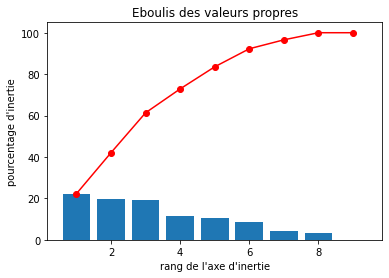

In [23]:
# choix du nombre de composantes à calculer
n_comp = 9

# selection des colonnes à prendre en compte dans l'ACP
#take = [additives_n, nutrition-score-uk_100g]
take = ["nutrition-score-uk_100g","serving_size","additives_n","energy_100g","fat_100g","saturated-fat_100g","carbohydrates_100g", "sugars_100g","fiber_100g","proteins_100g","salt_100g","sodium_100g"]
data_pca = data[["energy_100g","fat_100g","saturated-fat_100g","carbohydrates_100g", "sugars_100g","fiber_100g","proteins_100g","salt_100g","sodium_100g"]]

# préparation des données pour l'ACP
data_pca = data_pca.fillna(data_pca.mean())
X = data_pca.values
features = data_pca.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

plt.show()

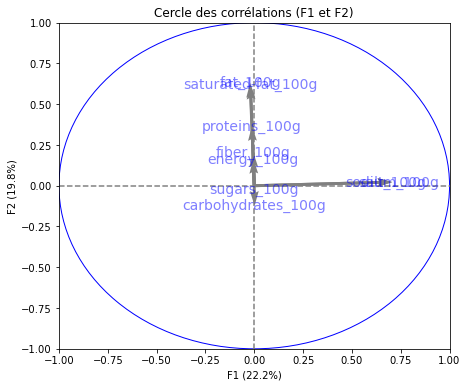

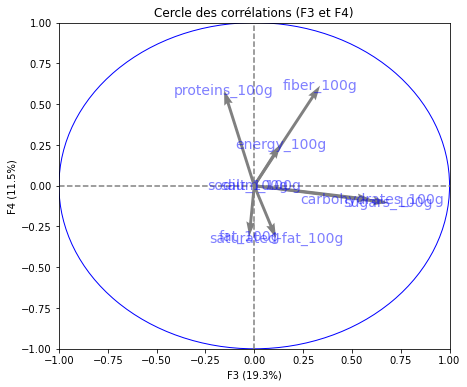

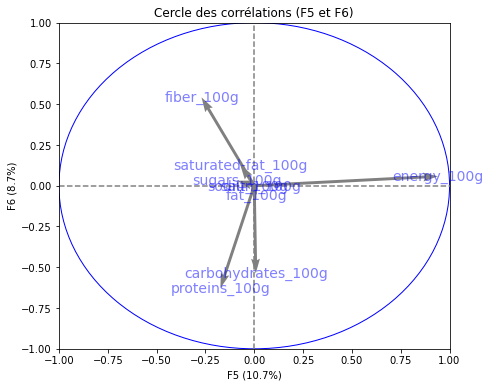

In [24]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))
plt.show()

In [ ]:
# Projection des individus
#names = data.index ??
#X_projected = pca.transform(X_scaled)
#display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(names))